Install dependencies

In [1]:
#!pip install mediapipe sklearn tensorflow tensorflow-gpu opencv-python matplotlib

In [24]:
!pip list

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import time
import tensorflow as tf
import os
import mediapipe as mp

In [27]:
mp_holistic = mp.solutions.holistic     #Holistic model
mp_drawing = mp.solutions.drawing_utils #Drawing utilities

In [28]:
def mediapipe_detection(image,model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Color conversion
    image.flags.writeable = False
    results = model.process(image)                 # Prediction
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # Color reversion
    return image,results

In [29]:
#Draw faces,pose and hand connections
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS)
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    

In [30]:
def draw_styled_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                                mp_drawing.DrawingSpec(color=(204, 0, 204), thickness=1, circle_radius=1),
                                mp_drawing.DrawingSpec(color=(51, 153, 0), thickness=1, circle_radius=1))
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(204, 0, 204), thickness=1, circle_radius=1),
                                mp_drawing.DrawingSpec(color=(51, 153, 0), thickness=1, circle_radius=1))
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(204, 0, 204), thickness=1, circle_radius=1),
                                mp_drawing.DrawingSpec(color=(51, 153, 0), thickness=1, circle_radius=1))
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(204, 0, 204), thickness=1, circle_radius=1),
                                mp_drawing.DrawingSpec(color=(51, 153, 0), thickness=1, circle_radius=1))

In [8]:
cap = cv2.VideoCapture(0)

#Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)        

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        #Break loop
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [9]:
len(results.pose_landmarks.landmark)

33

In [10]:
draw_styled_landmarks(frame, results)

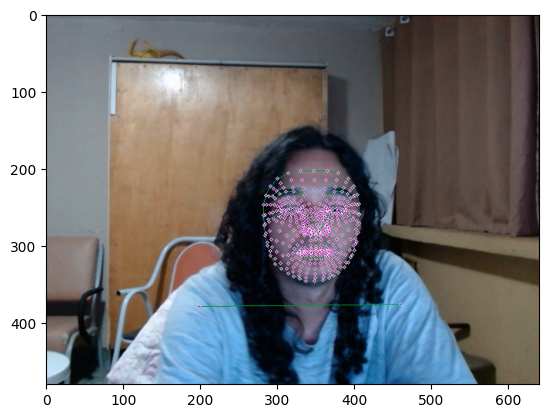

In [11]:
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

In [12]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    leftHand = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rightHand = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose,face,leftHand,rightHand])

In [13]:
result_test = extract_keypoints(results) #Checking results

In [14]:
result_test

array([ 0.551759  ,  0.59442973, -1.77813852, ...,  0.        ,
        0.        ,  0.        ])

In [15]:
np.save('0',result_test)

In [16]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_DATA')

# Actions that we try to detect
actions = np.array(['Ola', 'Obrigado','EuTeAmo'])

# Thirty videos worth of data
no_sequences = 30

# Size in frames per video
sequence_length = 30


In [19]:
#Folder Creation with the actions on it
for action in actions:  
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

In [20]:
cap = cv2.VideoCapture(0)

#Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        
        #loop through actions
        for action in actions:
            for sequence in range (no_sequences):
                #Loop through video length
                for frame_num in range(sequence_length):                    

                    # Read feed
                    ret, frame = cap.read()
                    
                    # Make detections
                    image, results = mediapipe_detection(frame, holistic)

                    # Draw landmarks
                    draw_styled_landmarks(image, results)                   
                    
                    if frame_num == 0:
                        #Modelling format
                        cv2.putText(image, 'Iniciando Coleta', (120,200),
                                   cv2.FONT_HERSHEY_SIMPLEX, 1 , (0,255,124),2,cv2.LINE_AA)
                        cv2.putText(image, 'Coletando {} frames para o video {}'.format(action,sequence), (15,12),
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5 , (0,255,0),1,cv2.LINE_AA)
                        
                        #Wait time of 2 seconds
                        cv2.waitKey(2000)
                        
                    else:
                         cv2.putText(image, 'Coletando frames para {} Video Num: {}'.format(action,sequence), (15,12),
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5 , (0,255,0),1,cv2.LINE_AA)
                    
                    #Save data on folders
                    keypoints = extract_keypoints(results)
                    npy_path = os.path.join(DATA_PATH, action,str(sequence),str(frame_num))
                    np.save(npy_path, keypoints)
                    
                    
                    #Showing the results
                    cv2.imshow('OpenCV Feed',image)

                    #Break loop
                    if cv2.waitKey(10) & 0xFF == ord('q'):
                        break
    cap.release()
    cv2.destroyAllWindows()

In [5]:
#!pip install -U scikit-learn
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


In [12]:
label_map = {label:num for num,label in enumerate(actions)}

In [14]:
sequences, labels = [],[]
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [17]:
X = np.array(sequences)

In [18]:
X.shape

(90, 30, 1662)

In [19]:
y = to_categorical(labels).astype(int)

In [20]:
X_train, X_test, y_train , y_test = train_test_split(X,y,test_size=0.05)

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [23]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir = log_dir)

In [25]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))


In [26]:
model.compile(optimizer='Adam', loss='categorical_crossentropy' , metrics=['categorical_accuracy'])

In [27]:
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

Epoch 1/2000
3/3 [==============================] - 4s 333ms/step - loss: 3.5241 - categorical_accuracy: 0.3412
Epoch 2/2000
3/3 [==============================] - 1s 323ms/step - loss: 5.1686 - categorical_accuracy: 0.4118
Epoch 3/2000
3/3 [==============================] - 1s 317ms/step - loss: 5.9570 - categorical_accuracy: 0.2824
Epoch 4/2000
3/3 [==============================] - 1s 314ms/step - loss: 4.8106 - categorical_accuracy: 0.3294
Epoch 5/2000
3/3 [==============================] - 1s 319ms/step - loss: 2.6649 - categorical_accuracy: 0.3176
Epoch 6/2000
3/3 [==============================] - 1s 345ms/step - loss: 2.4876 - categorical_accuracy: 0.3647
Epoch 7/2000
3/3 [==============================] - 1s 333ms/step - loss: 2.2138 - categorical_accuracy: 0.1882
Epoch 8/2000
3/3 [==============================] - 1s 341ms/step - loss: 2.3905 - categorical_accuracy: 0.3294
Epoch 9/2000
3/3 [==============================] - 1s 330ms/step - loss: 1.2326 - categorical_accuracy:

KeyboardInterrupt: 

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            442112    
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 596,675
Trainable params: 596,675
Non-trai

In [30]:
res = model.predict(X_test)

1/1 [==============================] - 0s 321ms/step


In [41]:
actions[np.argmax(res[2])]

'Obrigado'

In [42]:
actions[np.argmax(y_train[2])]

'Obrigado'

In [43]:
model.save('action.h5')

Reminder to Reload model
Re-Run Model Sequential
Re-compile it
and then

Model.load_weights('name_of_saved_model')

In [46]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [47]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 232ms/step


In [48]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [50]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[3, 1],
        [0, 1]],

       [[4, 0],
        [0, 1]],

       [[2, 0],
        [1, 2]]], dtype=int64)

In [51]:
accuracy_score(ytrue,yhat)

0.8

In [ ]:
# 1. New detection variables
sequence, sentence predictions = [], [], []

threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break Loop
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()